In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import os
import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tskit as tsk
 
from bgspy.models import BGSModel
from bgspy.genome import Genome
from bgspy.utils import bin_chrom, mean_ratio
from bgspy.data import GenomeData, pi_from_pairwise_summaries
from bgspy.sim_utils import mutate_simulated_tree
from bgspy.likelihood import FreeMutationModel, SimplexModel, FixedMutationModel

2022-12-03 19:03:59.451036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/vsb/projects/bprime/bgspy/data.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [4]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

## Functions

In [5]:
def sim_fit_plot(model, bins, Ys, bscores, mu, sh, loc=None, ratio=True):
    """
    Plot a likelihood fit (model) and the replicate sims (Ys)
    and compare to the correct B values.
    """
    transform = mean_ratio if ratio else lambda x: x
    for i, Y in enumerate(Ys):
        midpoints = [(s+e)/2 for c, s, e in bins.flat]
        lab = 'sim' if i == 0 else None
        plt.plot(midpoints, transform(pi_from_pairwise_summaries(Y)), label=lab, c='k', alpha=0.2)


    for i in range(10):
        plt.plot(midpoints, transform(model.predict(optim=i)), c='0.44', alpha=0.1)
    
    plt.plot(midpoints, transform(model.predict()), c='r', label='prediction')

    if ratio:
        x, y = bscores.pairs('chr10', mu, sh)
        plt.plot(x, transform(y), label='B', c='purple')

    plt.ylabel("$\pi/\\bar{\pi}$")
    plt.xlabel("position")
    plt.title(f"$\mu = {mu}, sh = {sh}, R^2 = {model.R2():.2}$")
    plt.legend(loc=loc, ncol=2)


In [6]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
#g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
#g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

In [7]:
# The B file for the conservation track used in the simulation
pkl_b_file= '../data/bmaps/bgspy/bmap_hg38_sims_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)

In [8]:
m

## Explore one Simulation Tree File

In [22]:
file = '../data/slim_sims/chrombgs_features_chr10/conserved_cds_utrs_phastcons_mle/sims/conserved_cds_utrs_phastcons_mle_N1000_mu2e-08_chr10_seed2906012675_rep0_treeseq.tree'
#file = '../data/test_trees/N10k/chrombgs_chr10_thresh0_N10k_N10000_mu1e-09_sh0.01_chr10_seed1818839066_rep37_treeseq.tree'
tree = tsk.load(file)
        
# load simulation data into GenomeData object
gd = GenomeData(g)
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

# mutate the tree sequence -- currently things are not recapitated(!)
gd.load_counts_from_ts(mutate_simulated_tree(tree, rate=1e-7), chrom='chr10')

In [23]:
# how many variants?
np.all(gd.counts['chr10'] > 0, axis=1).sum()

393848

How close are mutation and branch diversity?

In [24]:
gd

GenomeData (1 chromosomes)
Masks:
chrom      acc    neut    both
-------  -----  ------  ------
chr10      0.9    0.63    0.56
chromosome ends trimmed? False 

In [25]:
gd.accesssible_masks

{'chr10': array([ True,  True,  True, ...,  True,  True,  True])}

In [26]:
gd.counts['chr10'].shape

(133797422, 2)

In [27]:
tree.sequence_length, g.seqlens['chr10']

(133797422.0, 133797422)

  0%|          | 0/1 [00:00<?, ?it/s]

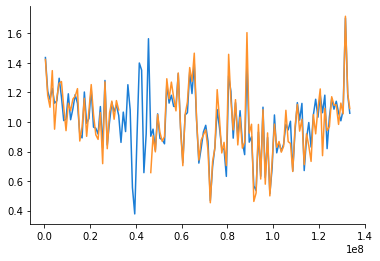

In [28]:
mb_bins = bin_chrom(tree.sequence_length, 1e6)
mb_mps = (mb_bins[1:] + mb_bins[:-1])/2
plt.plot(mb_mps, mean_ratio(tree.diversity(windows=mb_bins, mode='branch')))

pi_bins = gd.bin_pairwise_summaries(width=1e6)#, filter_accessible=True, filter_neutral=True)
xx, yy = pi_bins.pi_pairs('chr10')
plt.plot(xx, mean_ratio(yy))

## Load Human Data Data

Load real genomic data for comparison (e.g. to see how sims compare).

In [30]:
hg38_gd = GenomeData(g)
hg38_gd.load_counts_dir('../data/h1kg/hg1k_counts/')
hg38_gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
hg38_gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [31]:
hg38_bins = hg38_gd.bin_pairwise_summaries(width=1e6, filter_neutral=True, filter_accessible=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# how many variants?
np.all(hg38_gd.counts['chr10'] > 0, axis=1).sum()

1402597

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

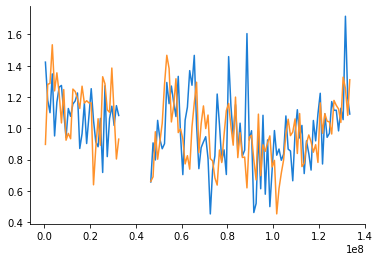

In [34]:
pi_bins = gd.bin_pairwise_summaries(width=1e6)
xx, yy = pi_bins.pi_pairs('chr10')
plt.plot(xx, mean_ratio(yy))

hg_pi_bins = hg38_gd.bin_pairwise_summaries(width=1e6)

xx, yy = hg_pi_bins.pi_pairs('chr10')
plt.plot(xx, mean_ratio(yy))

In [68]:
len(pi_bins['chr10'])

135

## Test Model Fits

In [78]:
regul_pkl = '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10000N_cds_utrs_regulatory_phastcons.pkl'
regul_m = BGSModel.load(regul_pkl)

In [81]:
sim_bins = gd.bin_pairwise_summaries(width=1e6)

  0%|          | 0/1 [00:00<?, ?it/s]

In [83]:
regul_b = sim_bins.bin_Bs(regul_m.BScores)
regul_bp = sim_bins.bin_Bs(regul_m.BpScores)

In [92]:
fmlik_nml = FreeMutationModel(w=w, t=t, logB=regul_bp[sim_bindat.chrom_indices('chr10'), ...],
                              bins=sim_bindat, Y=sim_bindat.Y(filter_masked=True))
fmlik_nml.fit(starts=10, ncores=70)

  0%|          | 0/10 [00:00<?, ?it/s]

In [95]:
fmlik_nml.features = regul_m.features

In [96]:
fmlik_nml

MLE (interpolated w): 6 x 5 x 8
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 449380172665.6773
π0 = 0.00047326913687657893
R² = 51.6017
W = 
          CTCF_binding_site    TF_binding_site    cds    enhancer    open_chromatin_region    phastcons    promoter    utr
------  -------------------  -----------------  -----  ----------  -----------------------  -----------  ----------  -----
1e-05                 0.475              0.066  0.131       0.543                    0.096        0.504       0.094  0.014
0.0001                0.089              0.249  0.044       0.012                    0.019        0.08        0.012  0.003
0.001                 0.093              0.364  0.035       0.012                    0.018        0.015       0.235  0.008
0.01                  0.051              0.014  0.043       0.01                     0.

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

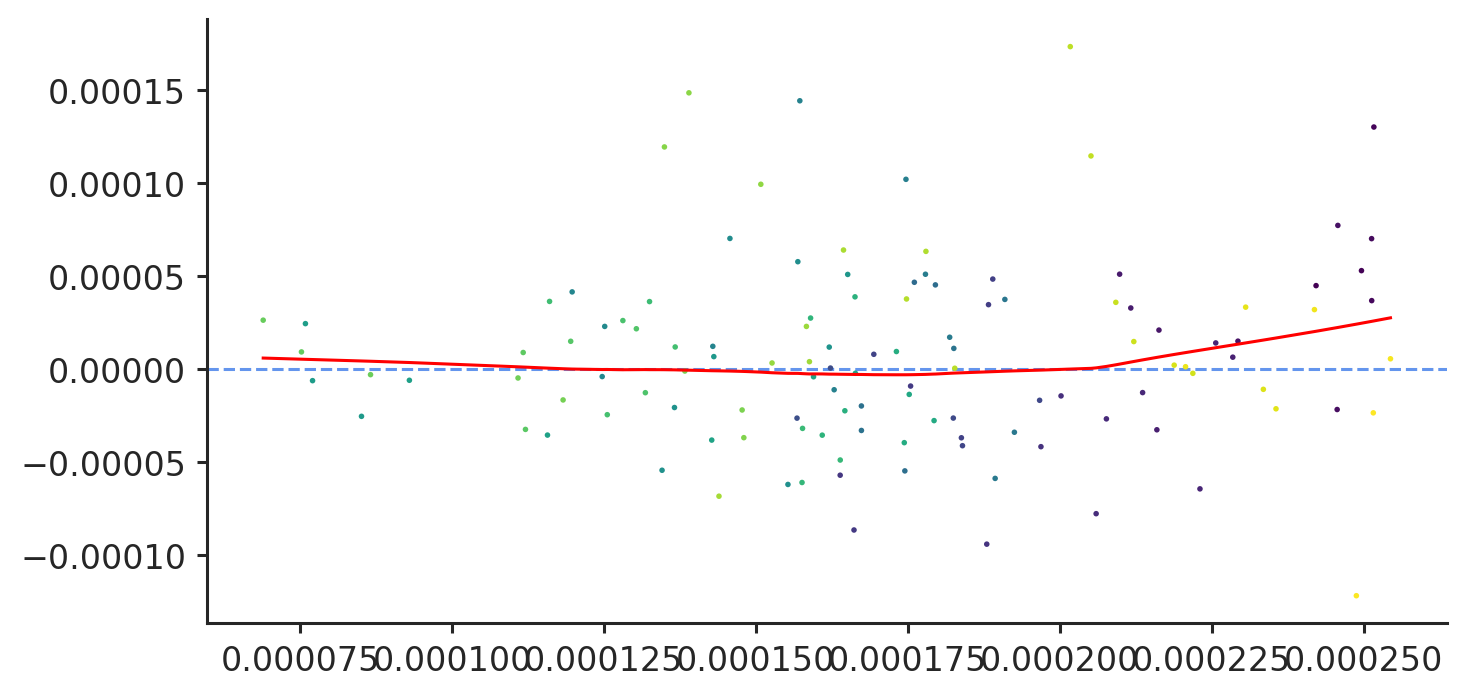

In [110]:
fmlik_nml.resid_fitted_plot()

In [103]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

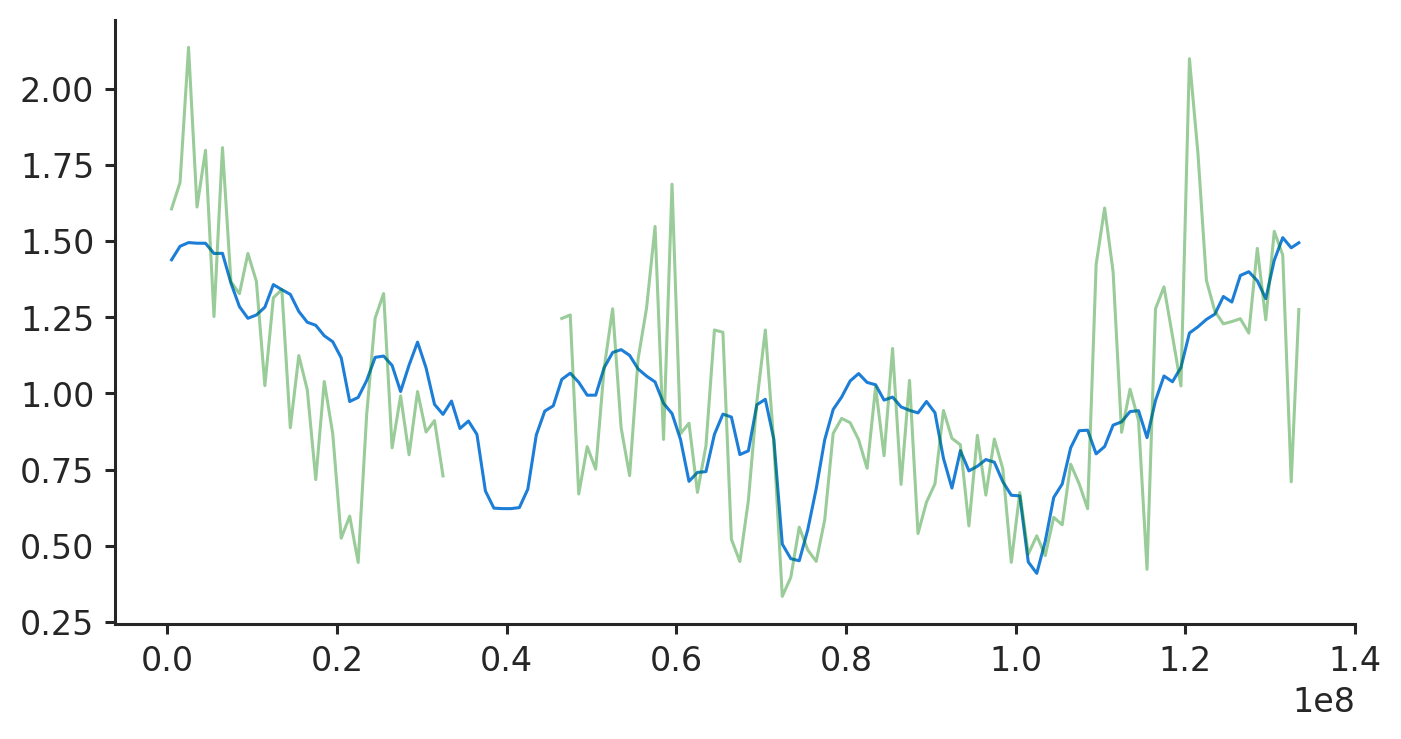

In [116]:
fmlik_nml.predict_plot('chr10', ratio=True)
#plt.plot(*hg38_bins.pi_pairs('chr10', ratio=True))
#plt.plot(bins.midpoints()['chr10'], mean_ratio(np.exp(Bp[:, 5, 4])), c='r')
#plt.plot(bins.midpoints()['chr10'], mean_ratio(np.exp(Bp[:, 4, 4])), c='purple')

In [117]:
fmlik_nml

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001   0.000316 0.001    0.00316  0.01     0.0316   0.1     ]

Free-mutation model ML estimates:
negative log-likelihood: 247615847518.0098
π0 = 0.0003052398878050735
W = 
--------  -----
0.0001    0.002
0.000316  0.002
0.001     0.002
0.00316   0.206
0.01      0.005
0.0316    0.301
0.1       0.482
--------  -----
μ = 
-----------
6.55067e-08
-----------

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


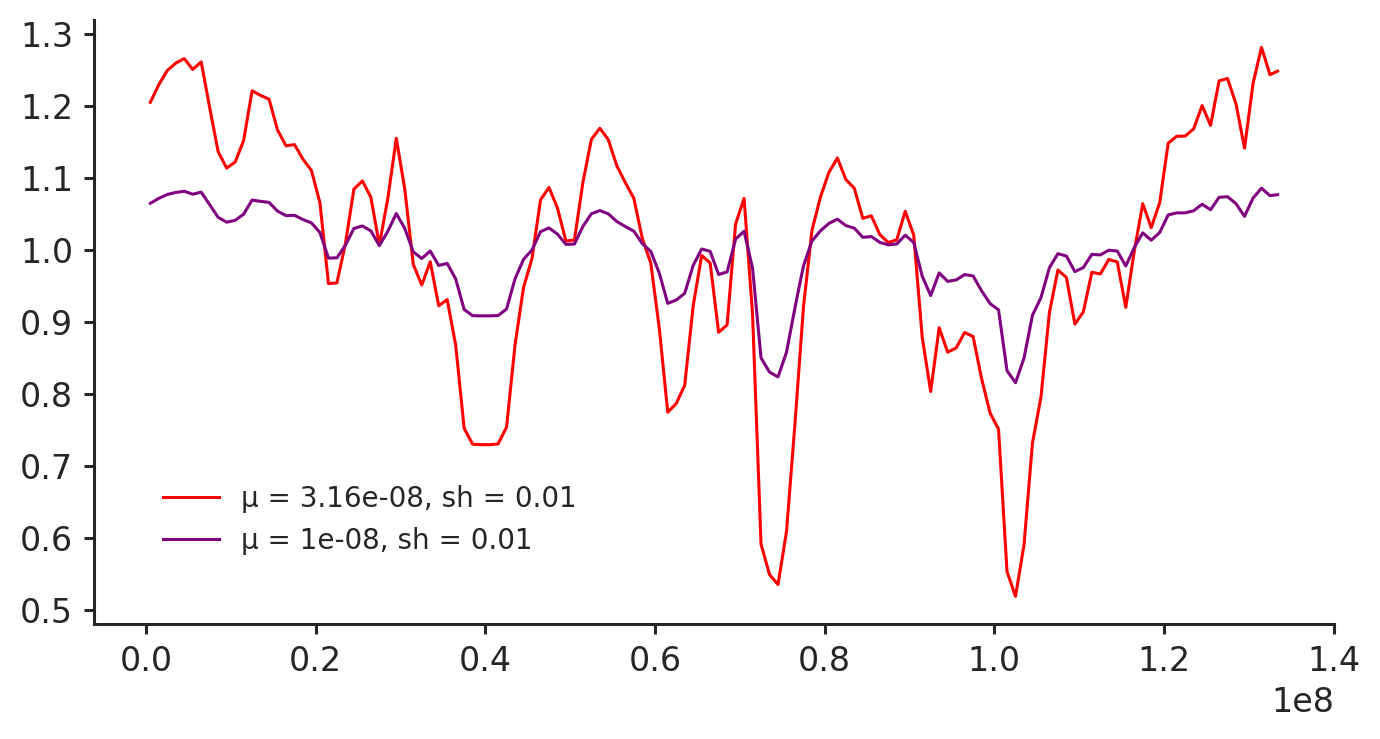

In [92]:
a = (5, 4)
plt.plot(bins.midpoints()['chr10'], mean_ratio(np.exp(Bp[:, 5, 4])), c='r', label=f"μ = {m.w[a[0]]}, sh = {m.t[a[1]]}")
b = (4, 4)
plt.plot(bins.midpoints()['chr10'], mean_ratio(np.exp(Bp[:, 4, 4])), c='purple',  label=f"μ = {m.w[b[0]]}, sh = {m.t[b[1]]}")
plt.legend()

In [105]:
slik_nml = SimplexModel(w=m.w, t=m.t, logB=Bp2, bins=bins2, Y=Ys2[0])
slik_nml.fit(starts=70, ncores=70, algo='ISRES')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:39<00:00,  1.42s/it]


In [106]:
slik_nml

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001   0.000316 0.001    0.00316  0.01     0.0316   0.1     ]

Simplex model ML estimates:
negative log-likelihood: 247729388547.78876
π0 = 0.00023650494639369758
μ = 3.159999977979877e-08
W = 
--------  -----
0.0001    0
0.000316  0
0.001     0
0.00316   0.541
0.01      0.238
0.0316    0.221
0.1       0
--------  -----

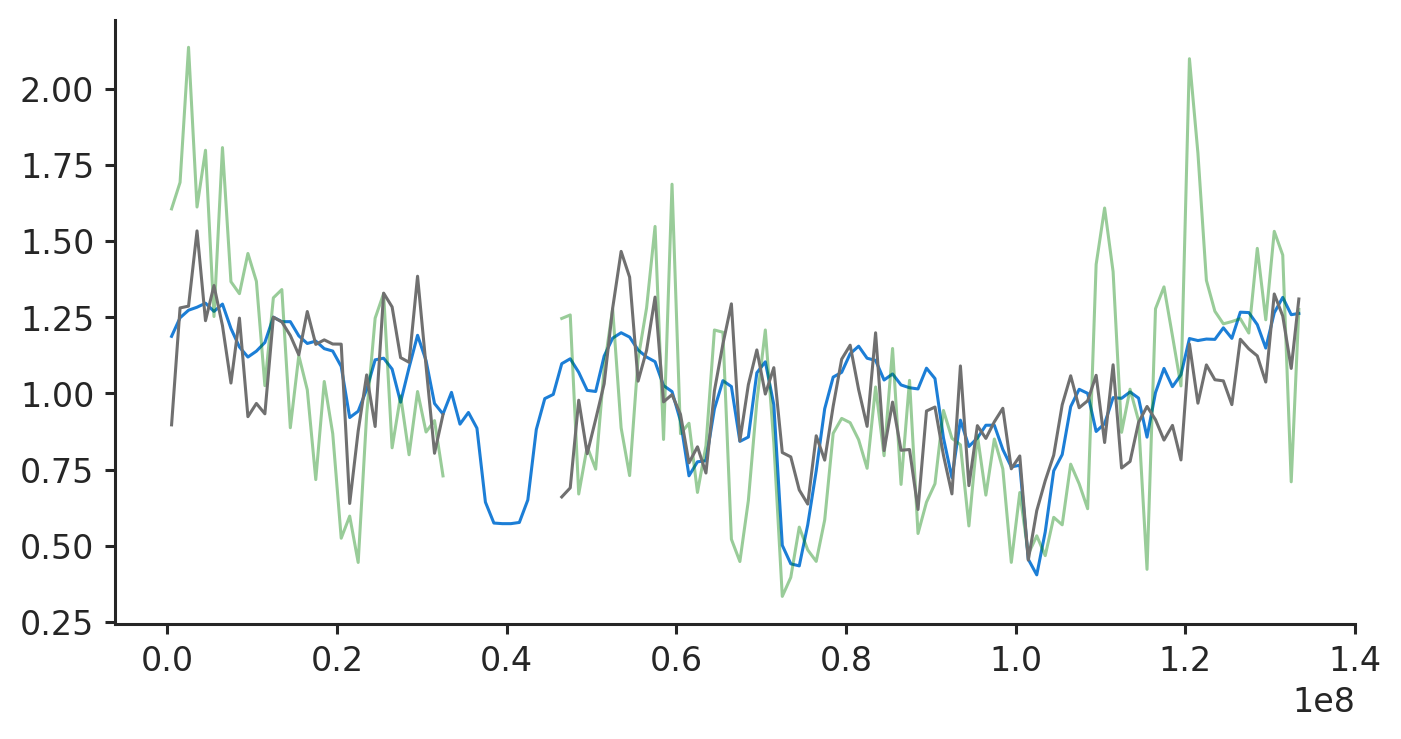

In [109]:
slik_nml.predict_plot('chr10', ratio=True)
plt.plot(*hg38_bins.pi_pairs('chr10', ratio=True), c='0.44')

In [137]:
np.var(pi_from_pairwise_summaries(Ys[0])), 2/9 * (1e-7 * 1000 * 4)**2

(5.433647453226744e-09, 3.555555555555555e-08)

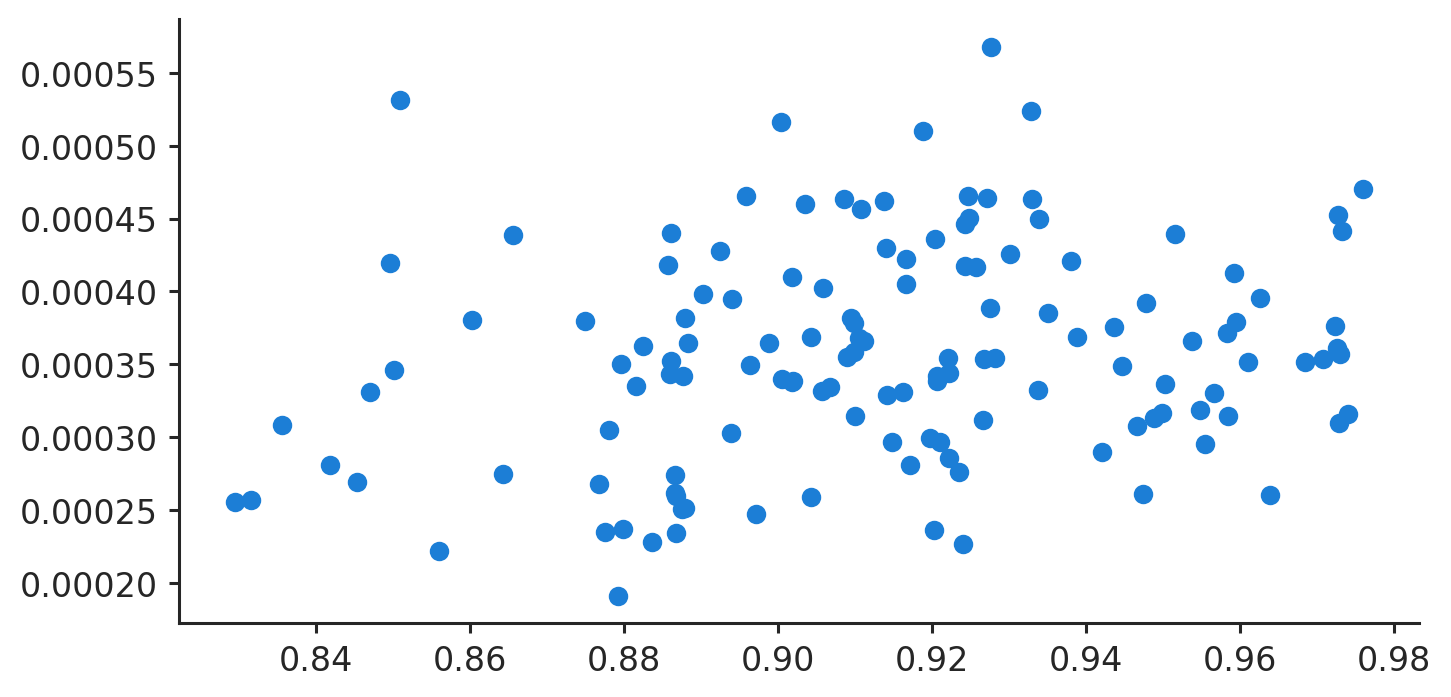

In [135]:
plt.scatter(np.exp(Bp[:, 4, 5, 0]), pi_from_pairwise_summaries(Ys[0]))

In [113]:
flik_nml = FixedMutationModel(w=m.w, t=m.t, logB=Bp2, bins=bins2, Y=Ys2[0])
flik_nml.fit(mu=3e-8, starts=100, ncores=70, algo='ISRES')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


In [114]:
flik_nml

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001   0.000316 0.001    0.00316  0.01     0.0316   0.1     ]

Fixed-Mutation Simplex model ML estimates:
negative log-likelihood: 247740121023.78152
π0 = 0.00023352390650931157
μ = 3e-08 (fixed)
W = 
--------  -----
0.0001    0
0.000316  0
0.001     0
0.00316   0.489
0.01      0.511
0.0316    0
0.1       0
--------  -----

In [ ]:
real_theta = np.array([2e-4, 0, 0, 0, 0, 1, 0, 0])
real_theta.size == m.t.size + 2

In [ ]:
m.BpScores

In [ ]:
model

In [24]:
flik_nml = FixedMutationModel(m.w, m.t, Bp, Y=Ys[0])
flik_nml.fit(mu=1e-8, starts=70, ncores=70, algo='ISRES')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [03:08<00:00,  2.69s/it]


In [29]:
flik_nml

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001   0.000316 0.001    0.00316  0.01     0.0316   0.1     ]

Fixed-Mutation Simplex model ML estimates:
negative log-likelihood: 851145270400.9254
π0 = 0.0003879326378457048
μ = 1e-08 (fixed)
W = 
--------  -----
0.0001    0
0.000316  0.589
0.001     0.411
0.00316   0
0.01      0
0.0316    0
0.1       0
--------  -----

In [75]:
flik_nml.mle_W.reshape(m.t.size, 1)

array([[8.88576583e-10],
       [5.88995930e-01],
       [4.11004056e-01],
       [1.74845711e-11],
       [3.73387376e-09],
       [5.73324922e-09],
       [3.07051538e-09]])

In [127]:


sim_fit_plot(flik_nml, bins, Ys, ratio=False)
#plt.plot(midpoints, model.predict(theta=np.array([4e-4, 0, 0, 0, 0, 1, 0, 0])), c='k', label='real θ')
#plt.plot(midpoints, model.predict(theta=np.array([4e-4, 0, 0.589, 0.411, 0, 0, 0, 0])), c='green', label='predicted B')


TypeError: sim_fit_plot() missing 3 required positional arguments: 'bscores', 'mu', and 'sh'

This seems to show a serious oddity in the simulations: there is a great deal more variance in any one replicate than we possibly see in real data.

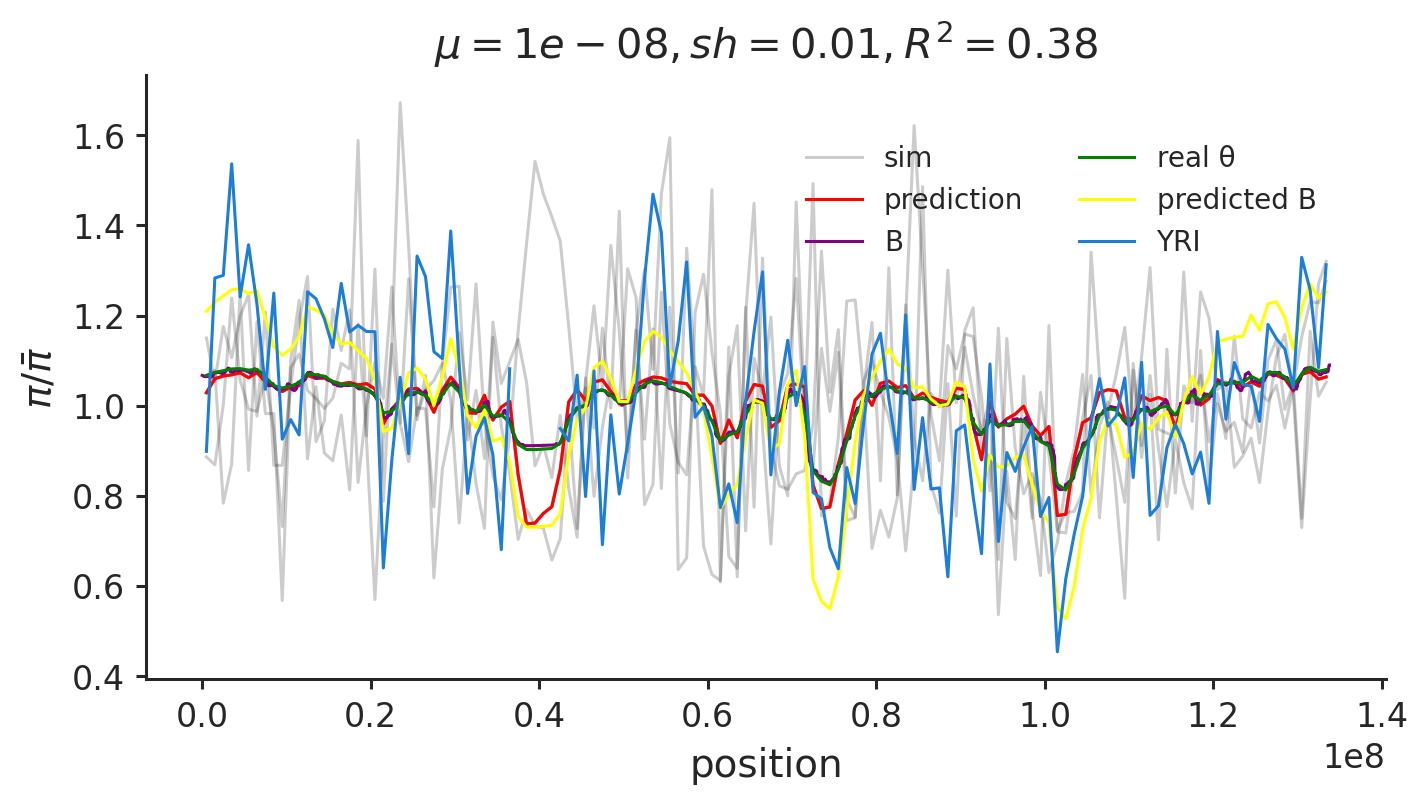

In [122]:

sim_fit_plot(flik_nml, bins, Ys, m.BpScores, 1e-8, 1e-2)

plt.plot(midpoints, mean_ratio(model.predict(theta=np.array([4e-4, 0, 0, 0, 0, 1, 0, 0]))), c='green', label='real θ')
#plt.plot(midpoints, mean_ratio(model.predict(theta=np.array([4e-4, 0, 0.589, 0.411, 0, 0, 0, 0]))), c='green', label='predicted B')
plt.plot(midpoints, mean_ratio(model.predict(theta=np.array([4e-4, 0, 0, 0, 0, 1, 0, 0]), mu=3.16e-8)), c='yellow', label='predicted B')

#plt.plot((midpoints, ratio(predict_simplex(np.array([2e-4, 1e-8, 0, 0, 0, 0, 1, 0, 0]), Bp, m.w))))

xx, yy = hg38_pi['chr10'].pairs
plt.plot(xx, mean_ratio(yy), label='YRI')
plt.legend(ncol=2)

In [119]:
flik_nml.optim.thetas_.mean(axis=0)

array([0.00088572, 0.08762073, 0.38788438, 0.38401795, 0.05250799,
       0.02877958, 0.02860545, 0.03058393])

In [ ]:
fmlik_nml = FreeMutationModel(m.w, m.t, Bp, Y=Ys[0])
fmlik_nml.fit(starts=100, ncores=70, algo='NELDERMEAD')

In [ ]:
fmlik_nml

In [ ]:

model = fmlik_nml


for Y in Ys:
    midpoints = [(s+e)/2 for c, s, e in bins.flat]
    plt.plot(midpoints, pi_from_pairwise_summaries(Y), label='sim')


for i in range(10):
    plt.plot(midpoints, model.predict(optim=i), c='0.44', alpha=0.1)
    
plt.plot(midpoints, model.predict(), c='r', label='prediction')

x, y = m.BpScores.pairs('chr10', 1e-8, 1e-3)
plt.plot(x, 4e-4*y, label='B', c='purple')


plt.plot(midpoints, model.predict(theta=np.array([4.5e-4, 0, 0, 0, 0, 1, 0, 0])), c='k', label='real θ')
#plt.plot((midpoints, ratio(predict_simplex(np.array([2e-4, 1e-8, 0, 0, 0, 0, 1, 0, 0]), Bp, m.w))))

plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {model.R2():.2}$")
plt.legend(loc='lower left', ncol=2)

In [ ]:
fmlik_nml2 = FreeMutationModel(m.w, m.t, Bp, Y=Ys[2])
fmlik_nml2.fit(starts=100, ncores=70, algo='NELDERMEAD')

In [ ]:
midpoints = [(s+e)/2 for c, s, e in bins.flat]
plt.plot(midpoints, pi_from_pairwise_summaries(Ys[2]))
plt.plot(midpoints, fmlik_nml2.predict(), c='r', label='prediction')


In [ ]:
from bgspy.likelihood import predict_simplex

plt.plot(midpoints, pi_from_pairwise_summaries(trim_Y), label='sim')

plt.plot(midpoints, predict_simplex(np.array([2.4e-4, 1e-8, 0, 0, 0, 1, 0, 0, 0]), Bp, m.w))

In [ ]:
slik_nml

In [ ]:
W = lik_nml.optim.thetas_[:100].mean(axis=0)[1:].reshape((5, 3))
W

In [ ]:
lik_nml.R2()

In [ ]:
lik_nml

In [ ]:
plt.scatter(pi_from_pairwise_summaries(trim_Y), lik_nml.predict())
plt.axline((0, 0), slope=1, c='r')

## Load a few Tree Files

In [ ]:

def load_sim_genomic_data(files, cons_track, access_mask, rate, chrom, winsize, bgs_model):
    sims_gds = []
    Ys = []
    bins = []
    for file in tqdm.tqdm(files):
        tree = tsk.load(os.path.join(tree_dir, file))
        
        # load simulation data into GenomeData object
        gd = GenomeData(g)
        gd.load_neutral_masks(cons_track)
        gd.load_accessibile_masks(access_mask)
        
        # mutate the tree sequence -- currently things are not recapitated(!)
        gd.load_counts_from_ts(mutate_simulated_tree(tree, rate=rate), chrom=chrom)
        sims_gds.append(gd)
        
        # calc Ys
        bgs_bins = gd.bin_pairwise_summaries(winsize, progress=False)
        bins.append(bgs_bins)
        Y = bgs_bins.Y()
        Ys.append(Y)
        
    # note assumes same bins -- TODO verify?
    bins = bins[0]
    B = bins.bin_Bs(bgs_model.BScores)
    Bp = bins.bin_Bs(bgs_model.BpScores)
    return sims_gds, bins, Ys, B, Bp

tree_dir = '../data/test_trees/mu1e-08_sh0.01/'
files = os.listdir(tree_dir)

sim_gds, bins, Ys, B, Bp = load_sim_genomic_data(files, 
                                            cons_track='../data/annotation/neutral_phastcons_genes_with_introns.bed.gz', 
                                            access_mask='../data/annotation/no_centro.bed', rate=1e-7, chrom='chr10',
                                            winsize=1e6, bgs_model=m)

  0%|                                                                                                                                                                                                                                                     | 0/3 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [93]:
tree_dir = '../data/test_trees/merged/'
files = os.listdir(tree_dir)
sim_gds2, bins2, Ys2, B2, Bp2 = load_sim_genomic_data(files, 
                                            cons_track='../data/annotation/neutral_phastcons_genes_with_introns.bed.gz', 
                                            access_mask='../data/annotation/no_centro.bed', rate=1e-7, chrom='chr10',
                                            winsize=1e6, bgs_model=m)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:23<00:00, 27.69s/it]


In [59]:
files

['chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed4013305247_rep58_treeseq.tree',
 'chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed3411287642_rep66_treeseq.tree',
 'chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed3308834955_rep22_treeseq.tree']

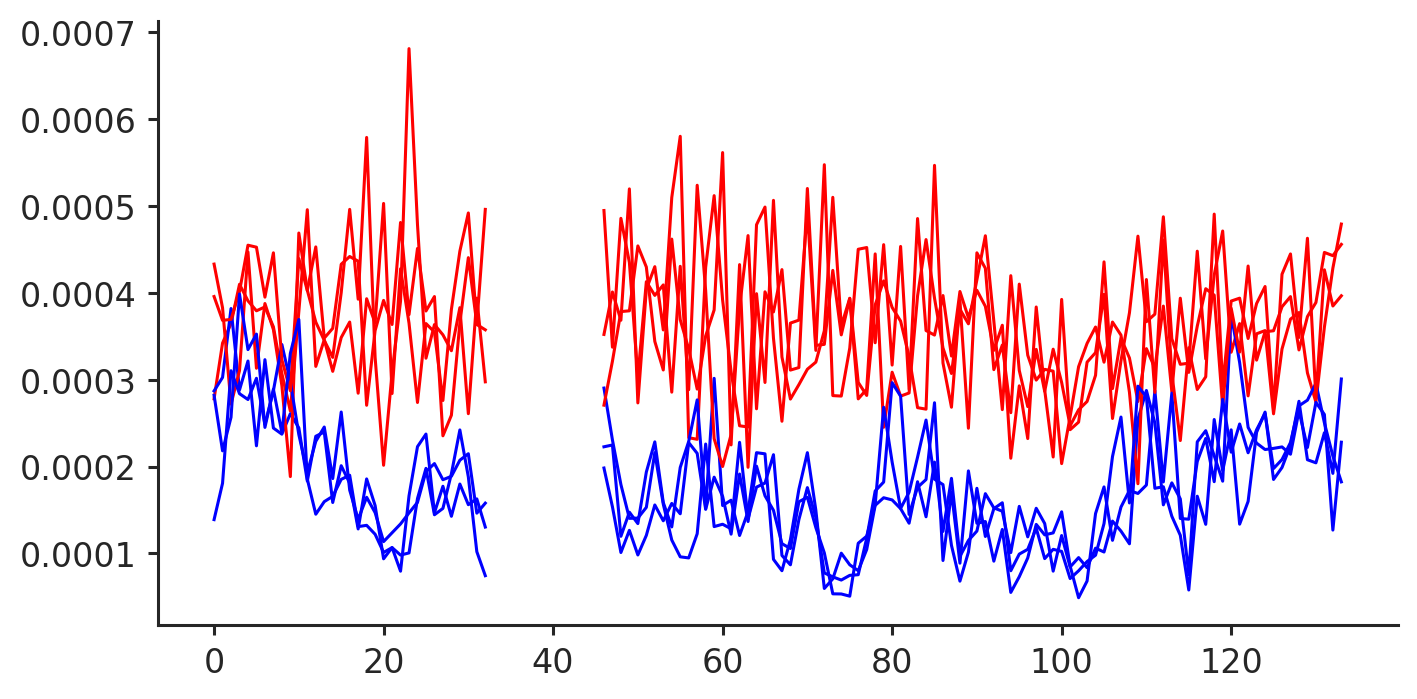

In [94]:
for i in range(3):
    plt.plot(pi_from_pairwise_summaries(Ys[i]), c='r')
    plt.plot(pi_from_pairwise_summaries(Ys2[i]), c='b')